# Финальная версия модели с продвинутым инжинирингом признаков и тюнингом (v2)

Этот блокнот содержит самую продвинутую версию модели с:
- Оптимизацией гиперпараметров через Optuna
- Продвинутым инжинирингом признаков
- Валидацией на отложенной выборке

### 1. Установка библиотек

In [ ]:
# Установка библиотек
%pip install catboost lightgbm xgboost scikit-learn pandas numpy optuna matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\seog\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
# 2. Импорты и настройки
import pandas as pd
import numpy as np
import warnings
import optuna
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

# Настройки для графиков
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)

C:\Users\seog\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Загрузка и преобработка данных

In [4]:
import re

def normalize_sem_name(sem_string):
    if pd.isna(sem_string):
        return sem_string
    
    s = str(sem_string).strip()
    
    # 1. Обработка формата "2023 - 2024II полугодие"
    if 'полугодие' in s:
        # Извлекаем годы (ищем две цифры после 20)
        years = re.findall(r'20(\d{2})', s)
        if len(years) >= 2:
            year_part = f"{years[0]}_{years[1]}"
        else:
            year_part = "unknown"
            
        # Определяем семестр
        sem_part = "semestr1" if "I полугодие" in s and "II" not in s else "semestr2"
        return f"{year_part}_{sem_part}"
    
    # 2. Обработка формата "22_23_semestr2" (оставляем как есть, если подходит)
    if re.match(r'\d{2}_\d{2}_semestr\d', s):
        return s
        
    return s # Если формат совсем другой



In [5]:
# Рассчитываем номер семестра от 1 до 8
# Формула: (Курс - 1) * 2 + (1 если I полугодие, 2 если II полугодие)

def get_relative_semester(row):
    course = int(row['Курс по порядку'])
    sem_val = 1 if "I полугодие" in str(row['semester']) else 2
    return (course - 1) * 2 + sem_val

In [ ]:
# Загрузка данных
marks_25 = pd.read_csv('marks_25_hash.csv')
print(f"Исходный размер данных: {marks_25.shape}")
print(marks_25.info())
print(marks_25.describe)
# Разворачиваем ЕГЭ: один предмет — один столбец
ege_pivot = marks_25.pivot_table(
    index='ld_number', 
    columns='Предметы ЕГЭ', 
    values='Баллы ЕГЭ', 
    aggfunc='max' # На случай, если есть дубликаты
).fillna(0) # Если предмет не сдавали, ставим 0

# Переименуем колонки для ясности
ege_pivot.columns = [f'EGE_{col}' for col in ege_pivot.columns]

# Предобработка оценок
marks_25['marks_final'] = marks_25['marks_final'].str.lower().fillna('неудовлетворительно')
neg_marks = ['не зачтено', 'не допущен', 'неявка', 'неявка по ув.причине']
marks_25['marks_final'] = marks_25['marks_final'].replace(neg_marks, 'неудовлетворительно')

# Конвертация в числовые оценки
marks_map = {'отлично': 5, 'хорошо': 4, 'удовлетворительно': 3, 'зачтено': 4, 'неудовлетворительно': 2}
marks_25['marks_final_numeric'] = marks_25['marks_final'].map(marks_map)

# Обработка дат
# Применяем нормализацию
marks_25['date_normalized'] = marks_25['date'].apply(normalize_sem_name)

# Сначала считаем средний балл (GPA) для каждой пары студент-семестр
# Используем свежесозданный столбец 'marks_final_numeric'
grouped_marks = marks_25.groupby(['ld_number', 'date_normalized'])['marks_final_numeric'].mean().reset_index()

# Теперь разворачиваем таблицу (pivot), используя результат группировки
sem_gpa = grouped_marks.pivot(
    index='ld_number', 
    columns='date_normalized', 
    values='marks_final_numeric'
).fillna(0)

# Переименовываем колонки
sem_gpa.columns = [f'gpa_{c}' for c in sem_gpa.columns]

# Собираем статичные признаки (Подразделение, Институты)
static_features = marks_25.groupby('ld_number').agg({
    'Подразделение': 'first',
    'Структурное подразделение': 'first',
    'Курс по порядку': 'max' # Текущий курс студента
}).reset_index()

# Объединяем всё в одну таблицу
df_final = static_features.merge(sem_gpa, on='ld_number', how='left')
df_final = df_final.merge(ege_pivot, on='ld_number', how='left')

# Заполняем пустоты в ЕГЭ нулями
df_final = df_final.fillna(0)

df_train = df_final[df_final['gpa_23_24_semestr2'] > 0]
drop_cols = ['gpa_24_25_semestr1', 'gpa_24_25_semestr2', 'gpa_25_26_semestr1','gpa_25_26_semestr2','gpa_26_27_semestr1','gpa_26_27_semestr2', 'gpa_27_28_semestr1'] 
X = df_train.drop(columns=drop_cols)
X

Исходный размер данных: (345096, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345096 entries, 0 to 345095
Data columns (total 19 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Баллы ЕГЭ                             263943 non-null  float64
 1   Предметы ЕГЭ                          274799 non-null  object 
 2   Вид контроля                          345071 non-null  object 
 3   Дата занятия                          303594 non-null  object 
 4   subject                               345071 non-null  object 
 5   marks                                 295968 non-null  object 
 6   marks_final                           303594 non-null  object 
 7   semester                              345071 non-null  object 
 8   year                                  345071 non-null  object 
 9   Дата начала обучения                  345096 non-null  object 
 10  Дата окончания обучения (по при

,ld_number,Подразделение,Структурное подразделение,Курс по порядку,gpa_17_18_semestr1,gpa_17_18_semestr2,gpa_18_19_semestr1,gpa_18_19_semestr2,gpa_19_20_semestr1,gpa_19_20_semestr2,...,gpa_23_24_semestr1,gpa_23_24_semestr2,EGE_Английский язык,EGE_Информатика и ИКТ,EGE_История,EGE_Математика,EGE_Обществознание,EGE_Русский язык,EGE_Физика,EGE_Химия
0,003ca3fd-5d19-564d-90e8-8bd945fb98bd,Институт информационных технологий и компьютер...,НИТУ МИСИС,4,0.0,0.0,0.0,0.0,0.0,0.0,...,4.100000,3.666667,0.0,62.0,0.0,68.0,0.0,96.0,0.0,0.0
1,00554462-f78b-57d8-87fa-7c0c57258f72,АИТ факультет/Б,"СТИ НИТУ ""МИСИС""",4,0.0,0.0,0.0,0.0,0.0,0.0,...,2.500000,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,006f7c88-052b-5157-add3-0a52b4c1f665,Институт экономики и управления промышленными ...,НИТУ МИСИС,4,0.0,0.0,0.0,0.0,0.0,0.0,...,4.307692,4.300000,0.0,0.0,0.0,62.0,76.0,66.0,0.0,0.0
3,008dfb6f-9d63-51ca-889d-6eb9becc7185,Институт информационных технологий и компьютер...,НИТУ МИСИС,4,0.0,0.0,0.0,0.0,0.0,0.0,...,4.100000,4.111111,0.0,92.0,0.0,100.0,0.0,80.0,0.0,0.0
4,01219bab-4f43-5304-95f2-f600373fe559,АИТ факультет/Б,"СТИ НИТУ ""МИСИС""",4,0.0,0.0,0.0,0.0,0.0,0.0,...,3.666667,3.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2217,ffc34a59-19fe-59e1-8cb9-cdcecea7efd7,Институт информационных технологий и компьютер...,НИТУ МИСИС,4,0.0,0.0,0.0,0.0,0.0,0.0,...,4.000000,2.000000,0.0,83.0,0.0,100.0,0.0,71.0,0.0,0.0
2218,ffdbe83b-bd79-5b3b-8c23-8092903dbab1,Институт новых материалов и нанотехнологий,НИТУ МИСИС,4,0.0,0.0,0.0,0.0,0.0,0.0,...,4.400000,4.250000,0.0,0.0,0.0,88.0,0.0,96.0,70.0,0.0
2219,ffe2d57e-f5b0-53bf-abcd-0ad761ef5136,ММТ факультет/Б,"СТИ НИТУ ""МИСИС""",4,0.0,0.0,0.0,0.0,0.0,0.0,...,3.571429,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2220,ffe2df1a-820e-555b-a6e5-949ebb331eff,Институт информационных технологий и компьютер...,НИТУ МИСИС,4,0.0,0.0,0.0,0.0,0.0,0.0,...,3.500000,3.750000,0.0,83.0,0.0,90.0,0.0,94.0,0.0,0.0


### 3. Продвинутый инжиниринг временных признаков

In [ ]:

''' print(X)

# Допустим, мы предсказываем семестр 23_24_sem1 (это наш Target)
target = 'gpa_24_25_semestr1'
X[target] = np.nan
# 1. Мы создаем "Средний балл за все прошлые семестры" вручную
# Берем только те колонки, которые были ДО целевой
past_semesters = [
    'gpa_17_18_semestr1', 'gpa_17_18_semestr2', 
    'gpa_18_19_semestr1', 'gpa_18_19_semestr2',
    'gpa_19_20_semestr1', 'gpa_19_20_semestr2',
    'gpa_20_21_semestr1', 'gpa_20_21_semestr2', 
    'gpa_21_22_semestr1', 'gpa_21_22_semestr2',
    'gpa_22_23_semestr1', 'gpa_22_23_semestr2',
    'gpa_23_24_semestr1', 'gpa_23_24_semestr2'
]

dataset_long = X.sort_values(by=['ld_number'])
grouped = dataset_long.groupby('ld_number')

dataset_long['avg_past_performance'] = dataset_long[past_semesters].replace(0, np.nan).mean(axis=1)
dataset_long['last_known_mark'] = dataset_long['gpa_23_24_semestr2'] # Последняя оценка перед таргетом
dataset_long['trend_last_year'] = dataset_long['gpa_23_24_semestr2'] - dataset_long['gpa_23_24_semestr1']
dataset_long['expanding_mean'] = grouped['avg_past_performance'].shift(1).expanding().mean().reset_index(0, drop=True)

# Список всех семестров по порядку
all_sems = ['gpa_17_18_semestr1', 'gpa_17_18_semestr2', 
    'gpa_18_19_semestr1', 'gpa_18_19_semestr2',
    'gpa_19_20_semestr1', 'gpa_19_20_semestr2',
    'gpa_20_21_semestr1', 'gpa_20_21_semestr2', 
    'gpa_21_22_semestr1', 'gpa_21_22_semestr2',
    'gpa_22_23_semestr1', 'gpa_22_23_semestr2',
    'gpa_23_24_semestr1', 'gpa_23_24_semestr2', 'gpa_24_25_semestr1']

# Мы можем создать много примеров для обучения из одного студента:
# Пример 1: знаем s1, s2 -> предсказываем s3
# Пример 2: знаем s1, s2, s3 -> предсказываем s4 '''

train_rows = []

for i in range(2, len(all_sems)):
    target_sem = all_sems[i]
    past_sems = all_sems[:i]
    
    # Берем данные
    temp_df = dataset_long[dataset_long[target_sem] > 0].copy()
    
    # Считаем признаки ТОЛЬКО по прошлым семестрам
    temp_df['target'] = temp_df[target_sem]
    temp_df['history_mean'] = temp_df[past_sems].replace(0, np.nan).mean(axis=1)
    temp_df['last_mark'] = temp_df[past_sems[-1]]
    
    # Оставляем только то, что знает модель: статику (ЕГЭ, Подразделение) + историю
    cols_to_keep = ['ld_number','Подразделение', 'Курс по порядку', 'history_mean', 'last_mark', 'target'] + [c for c in dataset_long.columns if 'EGE_' in c]
    train_rows.append(temp_df[cols_to_keep])

# Объединяем всё в один честный обучающий датасет
final_train_set = pd.concat(train_rows)
# Удаляем строки, где нет истории (самый первый семестр обучения), так как модели не на чем основывать прогноз
final_train_set = final_train_set.dropna(subset=['history_mean', 'last_mark'])

final_train_set

,ld_number,Подразделение,Курс по порядку,history_mean,last_mark,target,EGE_Английский язык,EGE_Информатика и ИКТ,EGE_История,EGE_Математика,EGE_Обществознание,EGE_Русский язык,EGE_Физика,EGE_Химия
137,11401f48-0ade-573d-8415-2a9f46b253ee,Факультет заочного обучения,4,2.875000,2.875000,2.812500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
690,4d52f56d-2507-5cb0-bc89-8cbd31311cda,"Выксунский филиал НИТУ ""МИСИС""",4,3.222222,3.222222,3.375000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2048,ec9987bf-4338-5cfe-94dd-348be60955af,"Выксунский филиал НИТУ ""МИСИС""",4,3.333333,3.333333,3.375000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
137,11401f48-0ade-573d-8415-2a9f46b253ee,Факультет заочного обучения,4,2.843750,2.812500,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
690,4d52f56d-2507-5cb0-bc89-8cbd31311cda,"Выксунский филиал НИТУ ""МИСИС""",4,3.298611,3.375000,3.375000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2217,ffc34a59-19fe-59e1-8cb9-cdcecea7efd7,Институт информационных технологий и компьютер...,4,3.729221,4.000000,2.000000,0.0,83.0,0.0,100.0,0.0,71.0,0.0,0.0
2218,ffdbe83b-bd79-5b3b-8c23-8092903dbab1,Институт новых материалов и нанотехнологий,4,4.262101,4.400000,4.250000,0.0,0.0,0.0,88.0,0.0,96.0,70.0,0.0
2219,ffe2d57e-f5b0-53bf-abcd-0ad761ef5136,ММТ факультет/Б,4,3.610431,3.571429,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2220,ffe2df1a-820e-555b-a6e5-949ebb331eff,Институт информационных технологий и компьютер...,4,3.859921,3.500000,3.750000,0.0,83.0,0.0,90.0,0.0,94.0,0.0,0.0


### 4. Разделение данных

In [16]:
# 1. Определяем признаки (X) и таргет (y)
# ld_number удаляем, чтобы модель не заучивала ID студентов
drop_cols = ['ld_number', 'target']
X = final_train_set.drop(columns=drop_cols)
y = final_train_set['target']

# 2. Категориальные признаки
cat_features = ['Подразделение'] 

# 3. Разбиваем на train/test
# Важно: здесь можно использовать обычный сплит, так как мы уже 
# разделили историю внутри каждой строки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")


Размер обучающей выборки: (11217, 12)
Размер тестовой выборки: (2805, 12)


### 5. Обучение модели CatBoost

In [ ]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

def objective(trial):
    param = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "random_strength": trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        "od_type": "Iter",
        "od_wait": 50,
        "verbose": False,
        "cat_features": cat_features,
        "allow_writing_files": False # Чтобы не плодить файлы во время тестов
    }
    
    model_opt = CatBoostRegressor(**param)
    model_opt.fit(X_train, y_train, eval_set=(X_test, y_test))
    
    preds = model_opt.predict(X_test)
    

    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse) 
    
    return rmse

# Запуск процесса оптимизации
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30) # Для начала 30 итераций

print("Лучшие параметры:", study.best_params)

# Обучаем модель с лучшими параметрами
best_params = study.best_params
best_params["iterations"] = 1000 # фиксируем количество итераций
best_params["cat_features"] = cat_features

final_model = CatBoostRegressor(**best_params)
final_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)

# Проверяем новый R2
final_pred = final_model.predict(X_test)
print(f"Улучшенный R2: {r2_score(y_test, final_pred):.4f}")




[I 2026-01-19 17:59:03,705] A new study created in memory with name: no-name-b1b43fd2-134e-4354-bbcb-e452747417ca
[I 2026-01-19 17:59:12,001] Trial 0 finished with value: 0.3581745250050259 and parameters: {'learning_rate': 0.01692773749278063, 'depth': 5, 'l2_leaf_reg': 0.1771943736585758, 'bootstrap_type': 'Bayesian', 'random_strength': 0.16046802655639034}. Best is trial 0 with value: 0.3581745250050259.
[I 2026-01-19 17:59:19,833] Trial 1 finished with value: 0.358324649274553 and parameters: {'learning_rate': 0.014301381945410445, 'depth': 5, 'l2_leaf_reg': 0.007919971470608907, 'bootstrap_type': 'Bayesian', 'random_strength': 0.22828673243000347}. Best is trial 0 with value: 0.3581745250050259.
[I 2026-01-19 17:59:31,319] Trial 2 finished with value: 0.3538270277614418 and parameters: {'learning_rate': 0.029984933615176512, 'depth': 10, 'l2_leaf_reg': 0.22398019267943636, 'bootstrap_type': 'Bayesian', 'random_strength': 1.1692990552533953}. Best is trial 2 with value: 0.353827027

Лучшие параметры: {'learning_rate': 0.038549817310093056, 'depth': 10, 'l2_leaf_reg': 0.0010026609864144955, 'bootstrap_type': 'Bayesian', 'random_strength': 6.4186071246220715}
0:	learn: 0.6446056	test: 0.6362170	best: 0.6362170 (0)	total: 38.7ms	remaining: 38.7s
100:	learn: 0.3498359	test: 0.3561112	best: 0.3561112 (100)	total: 3.28s	remaining: 29.2s
200:	learn: 0.3414479	test: 0.3536462	best: 0.3536095 (194)	total: 6.48s	remaining: 25.8s
300:	learn: 0.3327868	test: 0.3533282	best: 0.3533282 (300)	total: 10s	remaining: 23.3s
400:	learn: 0.3162314	test: 0.3538432	best: 0.3531073 (318)	total: 14.2s	remaining: 21.3s
500:	learn: 0.3031627	test: 0.3541893	best: 0.3531073 (318)	total: 18.3s	remaining: 18.3s
600:	learn: 0.2921102	test: 0.3548817	best: 0.3531073 (318)	total: 22.5s	remaining: 14.9s
700:	learn: 0.2825412	test: 0.3551281	best: 0.3531073 (318)	total: 26.6s	remaining: 11.4s
800:	learn: 0.2741103	test: 0.3561501	best: 0.3531073 (318)	total: 30.7s	remaining: 7.62s
900:	learn: 0.266

### 6. Обучение остальных моделей

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
import xgboost as xgb

# ==========================================
# 1. ПОДГОТОВКА И БАЗОВЫЕ МОДЕЛИ
# ==========================================

# --- Linear Regression (Базовая модель, без оптимизации) ---
# Кодируем категориальные признаки (get_dummies превратит текст в колонки 0/1)
X_train_encoded = pd.get_dummies(X_train, columns=['Подразделение'])
X_test_encoded = pd.get_dummies(X_test, columns=['Подразделение'])

# Важно: после get_dummies в train и test может оказаться разное кол-во колонок.
# Выравниваем их:
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

lr_model = LinearRegression()
lr_model.fit(X_train_encoded, y_train)

lr_preds = lr_model.predict(X_test_encoded)
print(f"Final Linear regression R2: {r2_score(y_test, lr_preds):.4f}")

# --- Decision Tree (С оптимизацией глубины) ---
def objective_dt(trial):
    # Подбираем глубину и минимальное количество объектов в листе
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 50)
    
    # Создаем и обучаем модель на ENCODED данных
    dt_model = DecisionTreeRegressor(
        max_depth=max_depth, 
        min_samples_leaf=min_samples_leaf, 
        random_state=42
    )
    dt_model.fit(X_train_encoded, y_train)
    
    # Считаем R2 на валидации
    preds = dt_model.predict(X_test_encoded)
    return r2_score(y_test, preds)

print("--- Оптимизация Decision Tree ---")
study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective_dt, n_trials=15)
print(f"Лучший R2 для Decision Tree: {study_dt.best_value:.4f}")
final_model_dt = DecisionTreeRegressor(**study_dt.best_params, random_state=42)
final_model_dt.fit(X_train_encoded, y_train) # Финальное обучение на всем train
# Предсказание тоже на закодированных данных
dt_preds = final_model_dt.predict(X_test_encoded)
print(f"Final Decision Tree R2: {r2_score(y_test, dt_preds):.4f}")

# ==========================================
# 2. БУСТИНГИ (XGBoost & LightGBM)
# ==========================================

# --- XGBoost ---
print("\n--- Оптимизация XGBoost ---")
def objective_xgb(trial):
    # Гиперпараметры для XGBoost
    params = {
        'n_estimators': 1000,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'tree_method': 'hist', # Быстрый метод для больших данных
        'random_state': 42
    }
    
    # ИСПОЛЬЗУЕМ ЗАКОДИРОВАННЫЕ ДАННЫЕ (X_train_encoded)
    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train_encoded, y_train,
        eval_set=[(X_test_encoded, y_test)],
        verbose=False
    )
    
    preds = model.predict(X_test_encoded)
    return r2_score(y_test, preds)

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=20)
print(f"Лучший R2 для XGBoost: {study_xgb.best_value:.4f}")
# Исправленная версия финального обучения XGBoost
final_model_xgb = xgb.XGBRegressor(**study_xgb.best_params, n_estimators=1500, n_jobs=-1, random_state=42)

final_model_xgb.fit(
    X_train_encoded, 
    y_train, 
    eval_set=[(X_test_encoded, y_test)], 
    verbose=False
)

# Проверка результата
xgb_preds = final_model_xgb.predict(X_test_encoded)
print(f"XGBoost Final R2: {r2_score(y_test, xgb_preds):.4f}")

import re

# Функция для очистки названий колонок от спецсимволов
def clean_column_names(df):
    # Заменяем все, что не буквы, цифры или подчеркивание, на подчеркивание
    df.columns = [re.sub(r'[^\w\s]', '_', str(col)) for col in df.columns]
    # Убираем двойные подчеркивания и пробелы
    df.columns = [col.replace(' ', '_').replace('__', '_') for col in df.columns]
    return df

# Очищаем оба датасета
X_train_encoded = clean_column_names(X_train_encoded)
X_test_encoded = clean_column_names(X_test_encoded)

print("Пример очищенных колонок:", X_train_encoded.columns[:5].tolist())

# --- LightGBM ---
print("\n--- Оптимизация LightGBM ---")
def objective_lgb(trial):
    # Параметры для подбора
    param = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    # Инициализируем модель (называем её просто model)
    model = lgb.LGBMRegressor(**param, n_estimators=1000, random_state=42)
    
    # Обучаем на ENCODED данных
    model.fit(
        X_train_encoded, y_train,
        eval_set=[(X_test_encoded, y_test)],
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
    )

    preds = model.predict(X_test_encoded)
    return r2_score(y_test, preds)

# Запуск Optuna
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=20)

print(f"Лучший R2 для LightGBM: {study_lgb.best_value:.4f}")

final_model_lgb = lgb.LGBMRegressor(**study_lgb.best_params, n_estimators=1500, random_state=42, verbosity=-1)

final_model_lgb.fit(
    X_train_encoded, y_train,
    eval_set=[(X_test_encoded, y_test)],
    callbacks=[lgb.early_stopping(50, verbose=False)]
)

lgb_preds = final_model_lgb.predict(X_test_encoded)
print(f"Финальный R2 LightGBM: {r2_score(y_test, lgb_preds):.4f}")




[I 2026-01-19 18:03:46,399] A new study created in memory with name: no-name-6ff938eb-1c21-4ebb-91b7-343aff118eb8
[I 2026-01-19 18:03:46,439] Trial 0 finished with value: 0.564415072004627 and parameters: {'max_depth': 17, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.564415072004627.
[I 2026-01-19 18:03:46,453] Trial 1 finished with value: 0.6682886719507004 and parameters: {'max_depth': 4, 'min_samples_leaf': 42}. Best is trial 1 with value: 0.6682886719507004.
[I 2026-01-19 18:03:46,477] Trial 2 finished with value: 0.6819403444910852 and parameters: {'max_depth': 9, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.6819403444910852.
[I 2026-01-19 18:03:46,494] Trial 3 finished with value: 0.690234781602572 and parameters: {'max_depth': 6, 'min_samples_leaf': 42}. Best is trial 3 with value: 0.690234781602572.
[I 2026-01-19 18:03:46,516] Trial 4 finished with value: 0.6842688773534368 and parameters: {'max_depth': 9, 'min_samples_leaf': 50}. Best is trial 3 with value: 0

Final Linear regression R2: 0.6821
--- Оптимизация Decision Tree ---


[I 2026-01-19 18:03:46,605] Trial 8 finished with value: 0.6767827593950384 and parameters: {'max_depth': 20, 'min_samples_leaf': 34}. Best is trial 3 with value: 0.690234781602572.
[I 2026-01-19 18:03:46,628] Trial 9 finished with value: 0.6870756520633452 and parameters: {'max_depth': 8, 'min_samples_leaf': 41}. Best is trial 3 with value: 0.690234781602572.
[I 2026-01-19 18:03:46,638] Trial 10 finished with value: 0.5958345364876139 and parameters: {'max_depth': 2, 'min_samples_leaf': 16}. Best is trial 3 with value: 0.690234781602572.
[I 2026-01-19 18:03:46,655] Trial 11 finished with value: 0.6871718139982584 and parameters: {'max_depth': 5, 'min_samples_leaf': 50}. Best is trial 3 with value: 0.690234781602572.
[I 2026-01-19 18:03:46,681] Trial 12 finished with value: 0.6799051141619574 and parameters: {'max_depth': 12, 'min_samples_leaf': 20}. Best is trial 3 with value: 0.690234781602572.
[I 2026-01-19 18:03:46,700] Trial 13 finished with value: 0.690234781602572 and parameters

Лучший R2 для Decision Tree: 0.6918
Final Decision Tree R2: 0.6918

--- Оптимизация XGBoost ---


[I 2026-01-19 18:03:49,747] Trial 0 finished with value: 0.6677484890191432 and parameters: {'max_depth': 9, 'learning_rate': 0.054738865642929777, 'subsample': 0.9484472944636306, 'colsample_bytree': 0.5345481060758294}. Best is trial 0 with value: 0.6677484890191432.
[I 2026-01-19 18:03:51,483] Trial 1 finished with value: 0.6985515710263323 and parameters: {'max_depth': 5, 'learning_rate': 0.016168481191573734, 'subsample': 0.7683976668488436, 'colsample_bytree': 0.8470093298595814}. Best is trial 1 with value: 0.6985515710263323.
[I 2026-01-19 18:03:54,677] Trial 2 finished with value: 0.6913926106581199 and parameters: {'max_depth': 9, 'learning_rate': 0.019005523087346897, 'subsample': 0.5080686623223409, 'colsample_bytree': 0.636760641459076}. Best is trial 1 with value: 0.6985515710263323.
[I 2026-01-19 18:03:57,539] Trial 3 finished with value: 0.6626687577233892 and parameters: {'max_depth': 8, 'learning_rate': 0.0424468688800288, 'subsample': 0.673102700257761, 'colsample_by

Лучший R2 для XGBoost: 0.7005


[I 2026-01-19 18:04:33,219] A new study created in memory with name: no-name-129af72c-1616-49cb-a471-3336ccec06ad


XGBoost Final R2: 0.6986
Пример очищенных колонок: ['Курс_по_порядку', 'history_mean', 'last_mark', 'EGE_Английский_язык', 'EGE_Информатика_и_ИКТ']

--- Оптимизация LightGBM ---
Training until validation scores don't improve for 50 rounds


[I 2026-01-19 18:04:38,116] Trial 0 finished with value: 0.705677632612993 and parameters: {'learning_rate': 0.012892734779953919, 'num_leaves': 1551, 'max_depth': 10, 'lambda_l1': 0.0001251476531261908, 'lambda_l2': 0.0059401562400254295, 'feature_fraction': 0.7509301017372652, 'bagging_fraction': 0.5512502504629946, 'bagging_freq': 2, 'min_child_samples': 25}. Best is trial 0 with value: 0.705677632612993.


Early stopping, best iteration is:
[322]	valid_0's rmse: 0.353518
Training until validation scores don't improve for 50 rounds


[I 2026-01-19 18:04:39,071] Trial 1 finished with value: 0.7032637530609855 and parameters: {'learning_rate': 0.014394127719074484, 'num_leaves': 232, 'max_depth': 6, 'lambda_l1': 0.12024913111779048, 'lambda_l2': 2.985808855725709, 'feature_fraction': 0.6877746440001086, 'bagging_fraction': 0.670656314517502, 'bagging_freq': 6, 'min_child_samples': 93}. Best is trial 0 with value: 0.705677632612993.


Early stopping, best iteration is:
[471]	valid_0's rmse: 0.354965
Training until validation scores don't improve for 50 rounds


[I 2026-01-19 18:04:39,898] Trial 2 finished with value: 0.7018265273082585 and parameters: {'learning_rate': 0.013516146155803465, 'num_leaves': 1502, 'max_depth': 3, 'lambda_l1': 4.7120673341622636e-08, 'lambda_l2': 1.904837790834961e-05, 'feature_fraction': 0.5576097836791665, 'bagging_fraction': 0.5555107286438021, 'bagging_freq': 4, 'min_child_samples': 59}. Best is trial 0 with value: 0.705677632612993.


Did not meet early stopping. Best iteration is:
[980]	valid_0's rmse: 0.355824
Training until validation scores don't improve for 50 rounds


[I 2026-01-19 18:04:40,086] Trial 3 finished with value: 0.7044636503136172 and parameters: {'learning_rate': 0.09629813443261796, 'num_leaves': 1884, 'max_depth': 4, 'lambda_l1': 0.13528441382032444, 'lambda_l2': 0.11867411248907711, 'feature_fraction': 0.9085895681757329, 'bagging_fraction': 0.751614108734605, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 0 with value: 0.705677632612993.


Early stopping, best iteration is:
[53]	valid_0's rmse: 0.354247
Training until validation scores don't improve for 50 rounds


[I 2026-01-19 18:04:40,753] Trial 4 finished with value: 0.704640484054909 and parameters: {'learning_rate': 0.024277559397925596, 'num_leaves': 1695, 'max_depth': 5, 'lambda_l1': 4.953172567658526e-06, 'lambda_l2': 2.035423277893894, 'feature_fraction': 0.6560798077727992, 'bagging_fraction': 0.9476005746106677, 'bagging_freq': 6, 'min_child_samples': 72}. Best is trial 0 with value: 0.705677632612993.


Early stopping, best iteration is:
[303]	valid_0's rmse: 0.354141
Training until validation scores don't improve for 50 rounds


[I 2026-01-19 18:04:41,328] Trial 5 finished with value: 0.7050179969697705 and parameters: {'learning_rate': 0.01905147830573344, 'num_leaves': 453, 'max_depth': 5, 'lambda_l1': 2.5133383771895835e-07, 'lambda_l2': 0.0023034892559807654, 'feature_fraction': 0.8690530733900876, 'bagging_fraction': 0.6628888678066959, 'bagging_freq': 7, 'min_child_samples': 16}. Best is trial 0 with value: 0.705677632612993.


Early stopping, best iteration is:
[282]	valid_0's rmse: 0.353914
Training until validation scores don't improve for 50 rounds


[I 2026-01-19 18:04:42,839] Trial 6 finished with value: 0.7050383343339951 and parameters: {'learning_rate': 0.03228485096555861, 'num_leaves': 1650, 'max_depth': 10, 'lambda_l1': 3.2793804007821556, 'lambda_l2': 0.0020671724859831343, 'feature_fraction': 0.7529657187617247, 'bagging_fraction': 0.7839717127726537, 'bagging_freq': 2, 'min_child_samples': 57}. Best is trial 0 with value: 0.705677632612993.


Early stopping, best iteration is:
[288]	valid_0's rmse: 0.353902
Training until validation scores don't improve for 50 rounds


[I 2026-01-19 18:04:43,517] Trial 7 finished with value: 0.6999041843202638 and parameters: {'learning_rate': 0.03387769903042841, 'num_leaves': 935, 'max_depth': 10, 'lambda_l1': 0.0004649182650742428, 'lambda_l2': 0.0004439946113144781, 'feature_fraction': 0.6335590183738855, 'bagging_fraction': 0.5382545774580794, 'bagging_freq': 5, 'min_child_samples': 89}. Best is trial 0 with value: 0.705677632612993.


Early stopping, best iteration is:
[173]	valid_0's rmse: 0.356969
Training until validation scores don't improve for 50 rounds


[I 2026-01-19 18:04:44,680] Trial 8 finished with value: 0.7059564647310013 and parameters: {'learning_rate': 0.015253821993228915, 'num_leaves': 1399, 'max_depth': 5, 'lambda_l1': 1.8789049916612464, 'lambda_l2': 0.002682585435647434, 'feature_fraction': 0.7429440306717006, 'bagging_fraction': 0.80595628663999, 'bagging_freq': 7, 'min_child_samples': 20}. Best is trial 8 with value: 0.7059564647310013.


Early stopping, best iteration is:
[520]	valid_0's rmse: 0.353351
Training until validation scores don't improve for 50 rounds


[I 2026-01-19 18:04:44,893] Trial 9 finished with value: 0.7006791324227652 and parameters: {'learning_rate': 0.030639874235369416, 'num_leaves': 507, 'max_depth': 3, 'lambda_l1': 7.468642085076161e-06, 'lambda_l2': 7.30743942918618, 'feature_fraction': 0.7266403283834194, 'bagging_fraction': 0.46718351042486433, 'bagging_freq': 7, 'min_child_samples': 38}. Best is trial 8 with value: 0.7059564647310013.


Early stopping, best iteration is:
[259]	valid_0's rmse: 0.356508
Training until validation scores don't improve for 50 rounds


[I 2026-01-19 18:04:45,836] Trial 10 finished with value: 0.7022054847994009 and parameters: {'learning_rate': 0.0532575701393156, 'num_leaves': 2968, 'max_depth': 8, 'lambda_l1': 6.121402743255187, 'lambda_l2': 3.6828359663237625e-07, 'feature_fraction': 0.4052723049042705, 'bagging_fraction': 0.9285532387705517, 'bagging_freq': 1, 'min_child_samples': 36}. Best is trial 8 with value: 0.7059564647310013.


Early stopping, best iteration is:
[321]	valid_0's rmse: 0.355597
Training until validation scores don't improve for 50 rounds


[I 2026-01-19 18:04:51,629] Trial 11 finished with value: 0.7048343165167275 and parameters: {'learning_rate': 0.010085972067618154, 'num_leaves': 2274, 'max_depth': 12, 'lambda_l1': 0.0010258262224241738, 'lambda_l2': 0.030701351349839014, 'feature_fraction': 0.8163822874036241, 'bagging_fraction': 0.850178692368976, 'bagging_freq': 3, 'min_child_samples': 28}. Best is trial 8 with value: 0.7059564647310013.


Early stopping, best iteration is:
[402]	valid_0's rmse: 0.354024
Training until validation scores don't improve for 50 rounds


[I 2026-01-19 18:04:54,320] Trial 12 finished with value: 0.7057086141245751 and parameters: {'learning_rate': 0.010180765877899628, 'num_leaves': 1099, 'max_depth': 8, 'lambda_l1': 0.012615061359201669, 'lambda_l2': 1.578819951474032e-05, 'feature_fraction': 0.9889807698475683, 'bagging_fraction': 0.6150216983737107, 'bagging_freq': 1, 'min_child_samples': 22}. Best is trial 8 with value: 0.7059564647310013.


Early stopping, best iteration is:
[398]	valid_0's rmse: 0.3535
Training until validation scores don't improve for 50 rounds


[I 2026-01-19 18:04:56,488] Trial 13 finished with value: 0.7094639008198231 and parameters: {'learning_rate': 0.010046366715926118, 'num_leaves': 960, 'max_depth': 7, 'lambda_l1': 0.031126786737792386, 'lambda_l2': 1.1962174630442289e-05, 'feature_fraction': 0.9938879759410865, 'bagging_fraction': 0.8334358527359553, 'bagging_freq': 1, 'min_child_samples': 8}. Best is trial 13 with value: 0.7094639008198231.


Early stopping, best iteration is:
[405]	valid_0's rmse: 0.351237
Training until validation scores don't improve for 50 rounds


[I 2026-01-19 18:04:57,945] Trial 14 finished with value: 0.709226992190175 and parameters: {'learning_rate': 0.017667714535854192, 'num_leaves': 957, 'max_depth': 7, 'lambda_l1': 0.23119309368702992, 'lambda_l2': 1.0372446822633276e-07, 'feature_fraction': 0.9709005036584738, 'bagging_fraction': 0.8647259504178988, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 13 with value: 0.7094639008198231.


Early stopping, best iteration is:
[249]	valid_0's rmse: 0.35138
Training until validation scores don't improve for 50 rounds


[I 2026-01-19 18:04:59,297] Trial 15 finished with value: 0.7071779379293037 and parameters: {'learning_rate': 0.02113074943785614, 'num_leaves': 856, 'max_depth': 7, 'lambda_l1': 0.021884148623786386, 'lambda_l2': 1.2205983687040144e-08, 'feature_fraction': 0.9992002145019776, 'bagging_fraction': 0.9089258333338383, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 13 with value: 0.7094639008198231.


Early stopping, best iteration is:
[219]	valid_0's rmse: 0.352616
Training until validation scores don't improve for 50 rounds


[I 2026-01-19 18:05:00,391] Trial 16 finished with value: 0.7056768478370115 and parameters: {'learning_rate': 0.01741071132773966, 'num_leaves': 89, 'max_depth': 7, 'lambda_l1': 0.0700338446685024, 'lambda_l2': 6.476905597824585e-07, 'feature_fraction': 0.9231304133397266, 'bagging_fraction': 0.9861346673172351, 'bagging_freq': 2, 'min_child_samples': 43}. Best is trial 13 with value: 0.7094639008198231.


Early stopping, best iteration is:
[269]	valid_0's rmse: 0.353519
Training until validation scores don't improve for 50 rounds


[I 2026-01-19 18:05:01,567] Trial 17 finished with value: 0.7068168719151318 and parameters: {'learning_rate': 0.045986553309620884, 'num_leaves': 659, 'max_depth': 9, 'lambda_l1': 0.0035411485938518653, 'lambda_l2': 1.131003625768005e-08, 'feature_fraction': 0.8423767900984027, 'bagging_fraction': 0.842310926173154, 'bagging_freq': 3, 'min_child_samples': 6}. Best is trial 13 with value: 0.7094639008198231.


Early stopping, best iteration is:
[70]	valid_0's rmse: 0.352833
Training until validation scores don't improve for 50 rounds


[I 2026-01-19 18:05:02,395] Trial 18 finished with value: 0.7044162512383271 and parameters: {'learning_rate': 0.02376083411883033, 'num_leaves': 1116, 'max_depth': 6, 'lambda_l1': 0.5976253027010648, 'lambda_l2': 8.786994278962538e-06, 'feature_fraction': 0.9494118799685802, 'bagging_fraction': 0.7384163309549846, 'bagging_freq': 1, 'min_child_samples': 71}. Best is trial 13 with value: 0.7094639008198231.


Early stopping, best iteration is:
[282]	valid_0's rmse: 0.354275
Training until validation scores don't improve for 50 rounds


[I 2026-01-19 18:05:10,098] Trial 19 finished with value: 0.7092644468460086 and parameters: {'learning_rate': 0.011659289234990749, 'num_leaves': 2171, 'max_depth': 12, 'lambda_l1': 0.00010124184430526774, 'lambda_l2': 2.0163611110794183e-07, 'feature_fraction': 0.4994844893688989, 'bagging_fraction': 0.869297915400018, 'bagging_freq': 4, 'min_child_samples': 15}. Best is trial 13 with value: 0.7094639008198231.


Early stopping, best iteration is:
[379]	valid_0's rmse: 0.351358
Лучший R2 для LightGBM: 0.7095
Финальный R2 LightGBM: 0.7095


### 7. Анализ результатов и визуализация

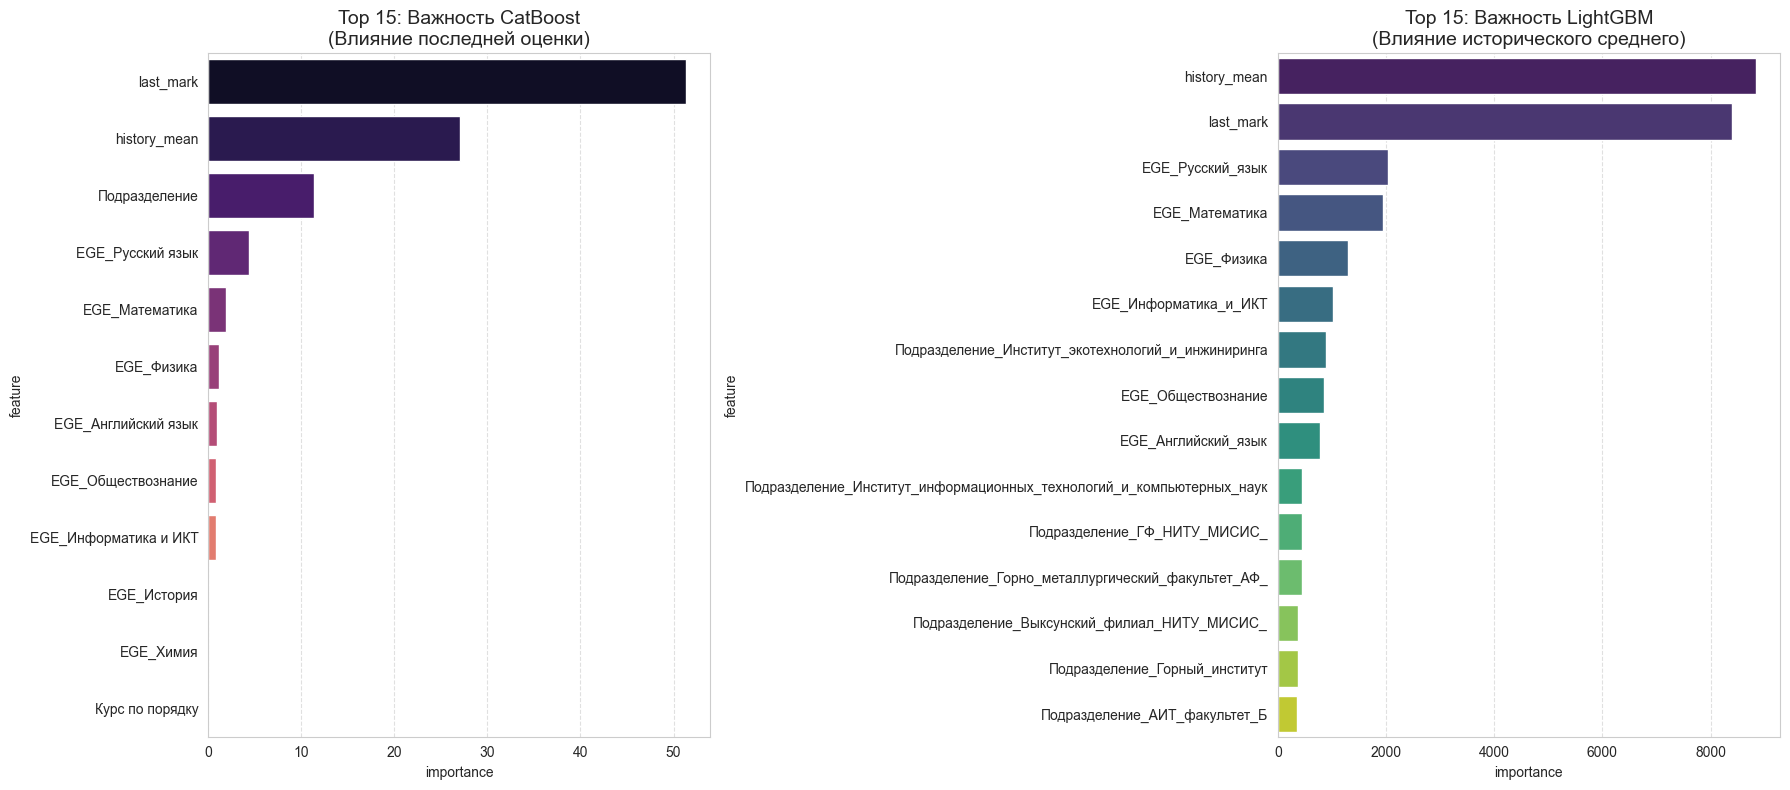

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 1. Готовим данные для CatBoost
fi_cat = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_model.get_feature_importance()
}).sort_values(by='importance', ascending=False).head(15)

# 2. Готовим данные для LightGBM
fi_lgb = pd.DataFrame({
    'feature': X_train_encoded.columns,
    'importance': final_model_lgb.feature_importances_
}).sort_values(by='importance', ascending=False).head(15)

# 3. Строим графики рядом
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# График CatBoost
sns.barplot(x='importance', y='feature', data=fi_cat, ax=axes[0], palette='magma')
axes[0].set_title('Top 15: Важность CatBoost\n(Влияние последней оценки)', fontsize=14)
axes[0].grid(axis='x', linestyle='--', alpha=0.6)

# График LightGBM
sns.barplot(x='importance', y='feature', data=fi_lgb, ax=axes[1], palette='viridis')
axes[1].set_title('Top 15: Важность LightGBM\n(Влияние исторического среднего)', fontsize=14)
axes[1].grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [21]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ОБЯЗАТЕЛЬНО: Обнуляем список перед сбором
results = []

def add_result(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    results.append({
        'Model': name,
        'R2': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': rmse
    })

# Добавляем актуальные результаты
add_result('LightGBM', y_test, lgb_preds)    # Тут ваши 0.7095
add_result('CatBoost', y_test, final_pred)  # Тут ваши 0.7064
add_result('XGBoost', y_test, xgb_preds)    # Тут ваши 0.6986
add_result('Trees', y_test, dt_preds)       # Тут ваши 0.6918
add_result('Linear Regression', y_test, lr_preds)

# Создаем таблицу
df_results = pd.DataFrame(results).sort_values(by='R2', ascending=False)

print("АКТУАЛЬНОЕ СРАВНЕНИЕ МОДЕЛЕЙ:")
print(df_results)

АКТУАЛЬНОЕ СРАВНЕНИЕ МОДЕЛЕЙ:
               Model        R2       MAE      RMSE
0           LightGBM  0.709464  0.263495  0.351237
1           CatBoost  0.706362  0.264836  0.353107
2            XGBoost  0.698645  0.265706  0.357717
3              Trees  0.691773  0.272019  0.361773
4  Linear Regression  0.682101  0.274453  0.367405


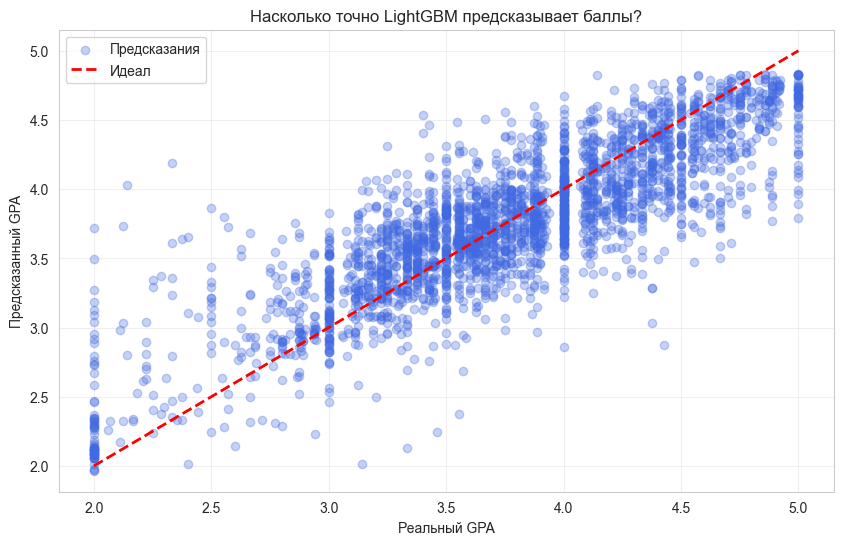

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Берем предсказания лучшей модели (LightGBM)
plt.scatter(y_test, final_pred, alpha=0.3, color='royalblue', label='Предсказания')

# Линия идеального прогноза
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Идеал')

plt.xlabel('Реальный GPA')
plt.ylabel('Предсказанный GPA')
plt.title('Насколько точно CatBoost предсказывает баллы?')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()